In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import cv2
from collections import defaultdict
from tqdm import tqdm
from fontTools.ttLib import TTFont
from PIL import Image, ImageDraw, ImageFont

def get_existing_chars(filename):
    ttfont = TTFont(filename)
    return list({chr(key) for table in ttfont['cmap'].tables for key in table.cmap.keys()})

def get_image(font, char, size=128):
    img = Image.new('L', (1000,1000), 255)

    draw = ImageDraw.Draw(img)
    draw.text((200,200), char, font=font)

    npimg = 255 - np.array(img)
    wmin = npimg.sum(0).nonzero()[0].min()
    wmax = npimg.sum(0).nonzero()[0].max()
    hmin = npimg.sum(1).nonzero()[0].min()
    hmax = npimg.sum(1).nonzero()[0].max()

    npimg = 255 - npimg[hmin:hmax+1,wmin:wmax+1]

    whdiff = (wmax-wmin) - (hmax-hmin)
    wmargin = abs(whdiff) // 2 if whdiff < 0 else 0
    hmargin = abs(whdiff) // 2 if whdiff >= 0 else 0

    npimg = np.pad(npimg, ((hmargin, hmargin), (wmargin, wmargin)),
                       'constant', constant_values=255)
    img = Image.fromarray(npimg)
    
    return img


def get_image_size(font, char, size=128):
    img = Image.new('L', (80,80), 255)

    draw = ImageDraw.Draw(img)
    draw.text((20,20), char, font=font)

    npimg = 255 - np.array(img)
    wmin = npimg.sum(0).nonzero()[0].min()
    wmax = npimg.sum(0).nonzero()[0].max()
    hmin = npimg.sum(1).nonzero()[0].min()
    hmax = npimg.sum(1).nonzero()[0].max()
    
    return wmax-wmin, hmax-hmin

def get_unpadded_borders(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    processed = cv2.morphologyEx(np.array(img), cv2.MORPH_CLOSE, kernel)
    npimg = 255 - np.array(processed)
    npimg[np.where(npimg < 16)] = 0
    wmin = npimg.sum(0).nonzero()[0].min()
    wmax = npimg.sum(0).nonzero()[0].max()
    hmin = npimg.sum(1).nonzero()[0].min()
    hmax = npimg.sum(1).nonzero()[0].max()
    return wmin, wmax, hmin, hmax


# utf-8
def get_all_korean():

    def nextKorLetterFrom(letter):
        lastLetterInt = 15572643
        if not letter:
            return '가'
        a = letter
        b = a.encode('utf8')
        c = int(b.hex(), 16)

        if c == lastLetterInt:
            return False

        d = hex(c + 1)
        e = bytearray.fromhex(d[2:])

        flag = True
        while flag:
            try:
                r = e.decode('utf-8')
                flag = False
            except UnicodeDecodeError:
                c = c+1
                d = hex(c)
                e = bytearray.fromhex(d[2:])
        return e.decode()

    returns = []
    flag = True
    k = ''
    while flag:
        k = nextKorLetterFrom(k)
        if k is False:
            flag = False
        else:
            returns.append(k)
    return returns

ak = get_all_korean()

def resize_with_padding(img, ratio, new_size, padding_color=255):
    # Open the image
    # Get the new dimensions based on the ratio
    new_width = int(img.width * ratio)
    new_height = int(img.height * ratio)
    
    # Resize the image using the new dimensions
    resized_img = img.resize((new_width, new_height), Image.BILINEAR)
    
    # Create a new blank image with padding
    padded_img = Image.new("L", (new_size, new_size), padding_color)
    
    # Calculate the position to paste the resized image
    left = (padded_img.width - resized_img.width) // 2
    top = (padded_img.height - resized_img.height) // 2
    right = left + resized_img.width
    bottom = top + resized_img.height
    
    # Paste the resized image onto the blank image
    padded_img.paste(resized_img, (left, top, right, bottom))
    
    return padded_img

In [2]:
ttffd = "/home/jupyter/ai_font/data/train_ttfs"
fd = "/home/jupyter/ai_font/data/train/"

fontfiles = sorted([(f.replace(".ttf",""), f"{ttffd}/{f}") for f in os.listdir(ttffd) if f.endswith(".ttf")])

In [3]:
font_size = 30
pbar = tqdm([f for i,f in enumerate(fontfiles)])
fontdicts = []
for fontname, filename in pbar:

    font = ImageFont.truetype(filename,font_size)
    existing_chars = get_existing_chars(filename)
    iter_chars = list(set(existing_chars).intersection(set(ak)))
    for l in iter_chars:
        try:
            w,h = get_image_size(font, l)
            fontdicts.append({
                "font": fontname,
                "letter": l,
                "w": w,
                "h": h,
            })
        except:
            pass

100%|██████████| 428/428 [20:58<00:00,  2.94s/it]


In [4]:
pd.DataFrame().from_dict(fontdicts).to_pickle("fontsizes.pickle")

0. get relative size ratio matrix of target font
1. find target letters of train fonts
2. make relative size ratio matrix
3. find top 4 fonts by cosine similarity
4. map average size of target letter to all letters as ratio
5. apply the ratio to target font

In [4]:
# Get size of target font 플레이브밤비
def unpadded_size(path):
    img = Image.open(path)
    wmin, wmax, hmin, hmax = get_unpadded_borders(img)
    return np.array(img)[wmin:wmax,hmin:hmax].shape

In [5]:

ak = get_all_korean()
fd = "/home/jupyter/ai_font/data/test/processed"
font = "플레이브밤비"
target_font_size_dict = {}
for path in tqdm(os.listdir(f"{fd}/{font}")):
    if path.endswith(".png"):
        letter = path.replace(".png","").split("__")[-1]
        if letter in ak:
            target_font_size_dict[letter] = unpadded_size(f"{fd}/{font}/{path}")

100%|██████████| 132/132 [00:00<00:00, 1255.29it/s]


In [6]:
target_mean = np.mean([np.max(v) for v in target_font_size_dict.values()])

In [7]:
target_mean

70.98765432098766

In [8]:
target_ratios = {}
for k,v in target_font_size_dict.items():
    target_ratios[k] = np.max(v)/target_mean

In [9]:
fontsizedf = pd.read_pickle("fontsizes.pickle")

In [10]:
fonts = np.unique(fontsizedf.font)
font_dict = {}

In [11]:
for f in tqdm(fonts):
    a = fontsizedf[fontsizedf.font == f]
    tempdict = pd.Series(index=a.letter, data = a[['w','h']].values.max(1)).to_dict()
    f_mean = np.mean([tempdict[k] for k in target_font_size_dict.keys() if k in tempdict.keys()])
    f_ratios = {k: tempdict[k]/f_mean for k,v in target_font_size_dict.items() if k in tempdict.keys()}
    letters = sorted(list(set(f_ratios.keys()) & set(target_ratios.keys()) ))
    # cs = cosine_similarity(np.array([[f_ratios[k] for k in letters]]),np.array([[target_ratios[k] for k in letters]])).item()
    cs = np.linalg.norm(np.log([f_ratios[k] for k in letters]) - np.log([target_ratios[k] for k in letters])).item()
    font_dict[f] = cs
    if np.isnan(cs):
        print(f)

100%|██████████| 422/422 [01:18<00:00,  5.38it/s]


In [12]:
# top8fonts = list(pd.Series(font_dict).sort_values()[-8:].index)
top8fonts = list(pd.Series(font_dict).sort_values()[:8].index)

In [13]:
from collections import defaultdict

f_ratios = defaultdict(list)
for f in tqdm(top8fonts):
    a = fontsizedf[fontsizedf.font == f]
    tempdict = pd.Series(index=a.letter, data = a[['w','h']].values.max(1)).to_dict()
    f_mean = np.mean([tempdict[k] for k in target_font_size_dict.keys() if k in tempdict.keys()])
    for k in ak:
        if k in tempdict.keys():
            f_ratios[k].append(tempdict[k]/f_mean)

100%|██████████| 8/8 [00:01<00:00,  5.33it/s]


In [14]:
t_sizes = {k: np.mean(v)*target_mean for k,v in f_ratios.items()}

In [15]:
def resize_n_pad(path, newsize, ssize = 128):
    img = Image.open(path).resize((ssize,ssize), Image.BILINEAR)
    wmin, wmax, hmin, hmax = get_unpadded_borders(img)
    gap = (wmax-wmin) - (hmax-hmin)
    if gap > 0:
        c = 0
        switch = True
        while c < abs(gap):
            if switch:
                if hmin > 0:
                    hmin -= 1
                    switch = not switch
                    c += 1
            else:
                if hmax < ssize:
                    hmax += 1
                    switch = not switch
                    c += 1
    else:
        c = 0
        switch = True
        while c < abs(gap):
            if switch:
                if wmin > 0:
                    wmin -= 1
                    switch = not switch
                    c += 1
                else:
                    switch = not switch
            else:
                if wmax < ssize:
                    wmax += 1
                    switch = not switch
                    c += 1
                else:
                    switch = not switch
    # newsize = int(t_sizes['탈'])
    img = Image.fromarray(np.array(img)[hmin:hmax,wmin:wmax]).resize((newsize,newsize), Image.BILINEAR)
    new_img = Image.new("L", (ssize,ssize), 255)
    paste_spot = (ssize-newsize)//2
    new_img.paste(img, (paste_spot,paste_spot))
    return new_img


In [21]:
tfont = "플레이브밤비"
reportfd = "/home/jupyter/ai_font/data/reports/exp0604/fontdiffuser_handcut/"
savefd = "/home/jupyter/ai_font/data/reports/exp0604/fontdiffuser_handcut_resized/"
os.makedirs(savefd, exist_ok=True)
for k, v in tqdm(t_sizes.items()):
    path = f"{reportfd}/fontdiffuser_phase2__{tfont}__{k}.png"
    if os.path.exists(path):
        newimg = resize_n_pad(path, int(t_sizes[k]))
        newimg.save(f"{savefd}/fontdiffuser_phase2__{tfont}__{k}.png")

100%|██████████| 11172/11172 [00:33<00:00, 329.17it/s]


In [22]:
k = '토'

In [23]:
path = f"{reportfd}/fontdiffuser_phase2__{tfont}__{k}.png"

In [24]:
if os.path.exists(path):
    newimg = resize_n_pad(path, int(t_sizes[k]))

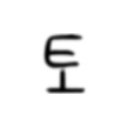

In [25]:
newimg

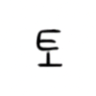

In [26]:
Image.open(path)

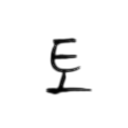

In [61]:
Image.open("/home/jupyter/ai_font/data/test/processed/플레이브밤비/플레이브밤비__closing__토.png")

In [63]:
t_sizes['토']

61.54390255807957

In [68]:
np.mean(f_ratios['토'])

0.8504019288987454

In [67]:
target_ratios['토']

0.8014329580348004

In [69]:
target_mean

72.37037037037037

In [102]:
path = "/home/jupyter/ai_font/data/test/processed/플레이브밤비/플레이브밤비__closing__토.png"
img = Image.open(path)
img = kimg
npimg = 255 - np.array(img)
npimg[np.where(npimg < 16)] = 0
wmin = npimg.sum(0).nonzero()[0].min()
wmax = npimg.sum(0).nonzero()[0].max()
hmin = npimg.sum(1).nonzero()[0].min()
hmax = npimg.sum(1).nonzero()[0].max()

In [103]:
wmin

60

In [104]:
wmax

88

In [105]:
hmin

54

In [106]:
hmax

93

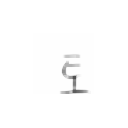

In [107]:
img

In [108]:
Image.fromarray(np.array(img)[hmin:hmax,wmin:wmax])

In [109]:
hmax-hmin

39

In [87]:
import cv2

In [89]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
processed = cv2.morphologyEx(np.array(img), cv2.MORPH_CLOSE, kernel)

In [93]:
kimg = Image.fromarray(processed)